[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/oscar-ramos/robotica-autonoma-python/blob/main/3-Intro-Vision/3-05-Matching.ipynb)

In [20]:
import numpy as np
from matplotlib import pyplot as plt

import cv2

Si se usa colab se puede utilizar las imágenes del repositorio, de lo contrario se pueden cargar manualmente.

In [ ]:
colab = True
if (colab):
    !wget -q https://github.com/oscar-ramos/robotica-autonoma-python/raw/main/3-Intro-Vision/imagenes/gatos.jpg
    !wget -q https://github.com/oscar-ramos/robotica-autonoma-python/raw/main/3-Intro-Vision/imagenes/gato3.jpg
    !wget -q https://github.com/oscar-ramos/robotica-autonoma-python/raw/main/3-Intro-Vision/imagenes/nasa_logo.png
    !wget -q https://github.com/oscar-ramos/robotica-autonoma-python/raw/main/3-Intro-Vision/imagenes/kennedy_space_center.jpg
    !wget -q https://github.com/oscar-ramos/robotica-autonoma-python/raw/main/3-Intro-Vision/imagenes/box.jpg
    !wget -q https://github.com/oscar-ramos/robotica-autonoma-python/raw/main/3-Intro-Vision/imagenes/box_in_scene.jpg
    !wget -q https://github.com/oscar-ramos/robotica-autonoma-python/raw/main/3-Intro-Vision/imagenes/gauguin_entre_les_lys.jpg
    !wget -q https://github.com/oscar-ramos/robotica-autonoma-python/raw/main/3-Intro-Vision/imagenes/gauguin_paintings.png

#1.&nbsp;Template Matching

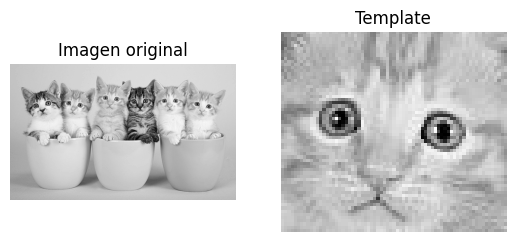

In [21]:
I = cv2.imread('gatos.jpg',0)
Itemplate = cv2.imread('gato3.jpg',0)
w, h = Itemplate.shape[::-1]

plt.subplot(121);
plt.imshow(I,cmap='gray'); plt.title('Imagen original'); plt.axis('off')
plt.subplot(122);
plt.imshow(Itemplate,cmap='gray'); plt.title('Template'); plt.axis('off')
plt.show()

Los posibles métodos para "template matching" son: `methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR', 'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']`


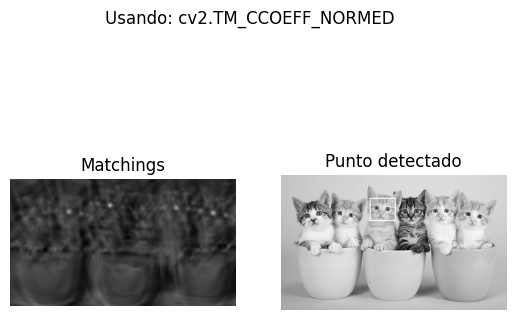

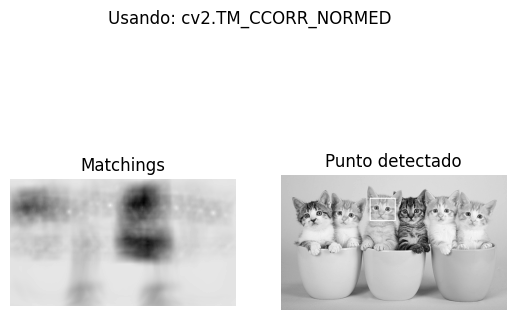

In [22]:
# Algunos métodos:
methods = ['cv2.TM_CCOEFF_NORMED','cv2.TM_CCORR_NORMED']

for method_str in methods:
    # Imagen de salida
    Iout = I.copy()
    # Métodos para template matching
    method = eval(method_str)
    # Aplicar template matching: Ires es la imagen con valore resultantes
    Ires = cv2.matchTemplate(I, Itemplate, method)
    # Extracción de máximos (y mínimos) valores de Ires
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(Ires)
    # Bordes del punto con mejor coincidencia (match)
    top_left = max_loc
    bottom_right = (top_left[0]+w, top_left[1]+h)
    # Rectángulo en el punto con mayor coincidencia
    cv2.rectangle(Iout, top_left, bottom_right, 255, 2)

    plt.subplot(121),
    plt.imshow(Ires, cmap='gray'); plt.title('Matchings'), plt.axis('off')
    plt.subplot(122)
    plt.imshow(Iout, cmap='gray'); plt.title('Punto detectado'), plt.axis('off')
    plt.suptitle("Usando: " + method_str)
    plt.show()

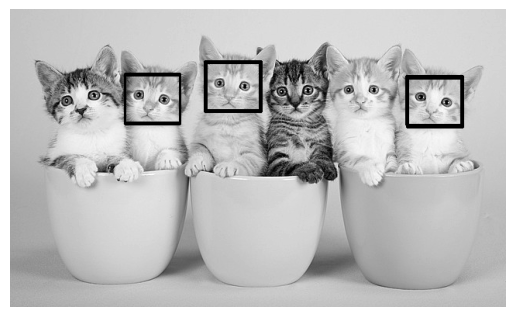

In [ ]:
# Mostrar más resultados (no solo el que hace más "match")
res = cv2.matchTemplate(I, Itemplate, cv2.TM_CCOEFF_NORMED)
threshold = 0.55
loc = np.where(res>=threshold)
for pt in zip(*loc[::-1]):
    cv2.rectangle(I, pt, (pt[0]+w, pt[1]+h), (0,0,255), 2)

plt.imshow(I, cmap='gray')
plt.axis('off'); plt.show()

# 2.&nbsp;Matching usando ORB

In [26]:
# Carga de las imágenes
I1 = cv2.imread('nasa_logo.png', cv2.IMREAD_GRAYSCALE)
I2 = cv2.imread('kennedy_space_center.jpg', cv2.IMREAD_GRAYSCALE)

# Obtención de descriptores ORB en ambas imágenes
orb = cv2.ORB_create()
keypts1, descriptores1 = orb.detectAndCompute(I1, None)
keypts2, descriptores2 = orb.detectAndCompute(I2, None)

## 2.1. Usando fuerza bruta

In [27]:
# Matching (correspondencia) por fuerza bruta
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptores1, descriptores2)

# Ordenar las correspondencias ("matches") por distancia
matches = sorted(matches, key=lambda x:x.distance)

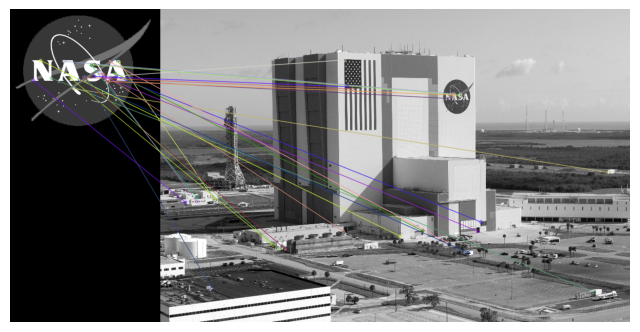

In [33]:
# Dibujar las mejores 25 correspondencias
Imatches = cv2.drawMatches(I1, keypts1, I2, keypts2, matches[:25], I2,
                           flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

# Mostrar las correspondencias
plt.figure(figsize=(8,8))
plt.imshow(Imatches)
plt.axis('off'); plt.show()

## 2.2. Usando k-vecinos más cercanos

In [ ]:
# Uso de fuerza bruta con k-NN para k=2 (2 mejores correspondencias por punto)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
pares_de_matches = bf.knnMatch(descriptores1, descriptores2, k=2)

# Ordenar los pares de puntos por distancia
pares_de_matches = sorted(pares_de_matches, key=lambda x:x[0].distance)

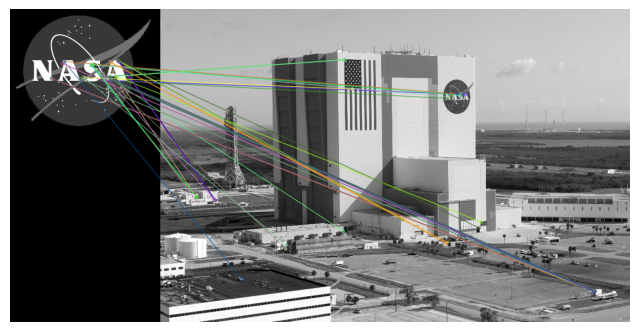

In [34]:
# Escoger los mejores 25 pares
Imatches2 = cv2.drawMatchesKnn(I1, keypts1, I2, keypts2,
                               pares_de_matches[:25], I2,
                               flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

# Mostrar las corresponencias
plt.figure(figsize=(8,8))
plt.imshow(Imatches2)
plt.axis('off'); plt.show()

## 2.3. Usando la distancia NNDR

In [ ]:
# Realizar la prueba
NNDR = 0.75
matches = [x[0] for x in pares_de_matches
           if len(x) > 1 and x[0].distance < NNDR * x[1].distance]

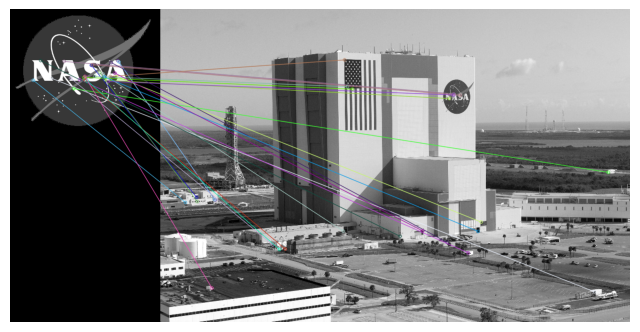

In [35]:
# Escoger los mejores 25 pares
Imatches3 = cv2.drawMatches(I1, keypts1, I2, keypts2, matches[:25], I2,
                            flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

# Mostrar las corresponencias
plt.figure(figsize=(8,8))
plt.imshow(Imatches3)
plt.axis('off'); plt.show()

# 3.&nbsp;Matching usando ORB y FLANN

In [37]:
I1 = cv2.imread('box.jpg',0)            # queryImage
I2 = cv2.imread('box_in_scene.jpg',0)   # trainImage

# Descriptor ORB
orb = cv2.ORB_create()

# 'Keypoints' y descriptores para cada imagen (usando ORB)
keypts1, descript1 = orb.detectAndCompute(I1, None)
keypts2, descript2 = orb.detectAndCompute(I2, None)

FLANN significa "Fast Library for Approximate Nearest Neighbors" y se utiliza para realizar matching utilizando vecinos más cercanos. El github del proyecto es: https://github.com/flann-lib/flann. Más información sobre este ejemplo se puede encontrar [aquí](https://docs.opencv.org/4.8.0/dc/dc3/tutorial_py_matcher.html)

In [38]:
FLANN_INDEX_LSH = 6
# Parámetros sugeridos para FLANN con ORB
index_params= dict(algorithm = FLANN_INDEX_LSH, table_number = 6,
                   key_size = 12, multi_probe_level = 1)

# Número de veces que el índice se debe buscar en el árbol (mayores valores
# dan mayor precisión, pero demoran más)
search_params = dict(checks = 50)

# Instancia de FLANN
flann = cv2.FlannBasedMatcher(index_params, search_params)
# Usando K-NN para match
matches = flann.knnMatch(descript1, descript2, k=2)

In [39]:
# Máscara para quedarse con los buenos "matches"
matchesMask = [[0,0] for i in range(len(matches))]
NNDR = 0.7
# Test de "ratio"
for i, match in enumerate(matches):
    # Descartar "matches" que tienen menos de 2 componentes (por "bug"?)
    if (len(match)<2): continue
    # Separación de elementos del match
    (m, n) = match
    if (m.distance < NNDR*n.distance):
        matchesMask[i]=[1,0]

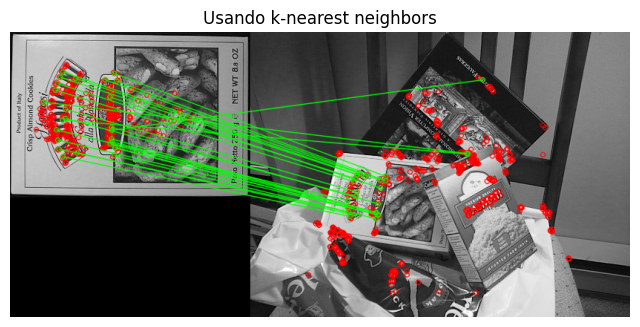

In [40]:
# Dibujar los "matches"
draw_params = dict(matchColor = (0,255,0), singlePointColor = (255,0,0),
                   matchesMask = matchesMask, flags = 0)

Iflann = cv2.drawMatchesKnn(I1, keypts1, I2, keypts2, matches,
                            None, **draw_params)

plt.figure(figsize=(8,8))
plt.imshow(Iflann); plt.axis('off'); plt.title('Usando k-nearest neighbors')
plt.show()

# 4.&nbsp;Matching usando SIFT

In [41]:
I1 = cv2.imread('gauguin_entre_les_lys.jpg', cv2.IMREAD_GRAYSCALE)
I2 = cv2.imread('gauguin_paintings.png', cv2.IMREAD_GRAYSCALE)

# Atributos importantes con el descritor SIFT
sift = cv2.SIFT_create()
keypts1, descriptores1 = sift.detectAndCompute(I1, None)
keypts2, descriptores2 = sift.detectAndCompute(I2, None)

In [42]:
# Parámetros de FLANN para ser usados con SIFT
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50) # A más chequeos, más exactitud (más lento)

# Correspondencias con FLANN
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(descriptores1, descriptores2, k=2)

# Máscara vacía para dibujar
mask_matches = [[0, 0] for i in range(len(matches))]
# Llenar valores usando el ratio
NNDR = 0.6
for i, (m, n) in enumerate(matches):
    if m.distance < NNDR * n.distance:
        mask_matches[i]=[1, 0]

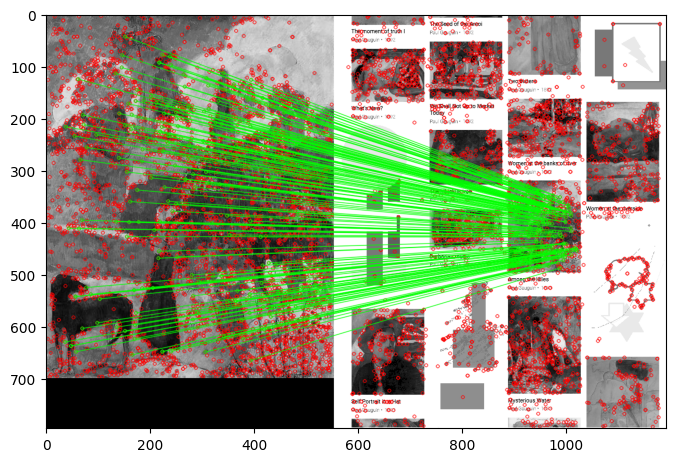

In [43]:
# Dibujo de las correspondencias
img_matches = cv2.drawMatchesKnn(I1, keypts1, I2, keypts2, matches, None,
                                 matchColor=(0, 255, 0),
                                 singlePointColor=(255, 0, 0),
                                 matchesMask=mask_matches, flags=0)

# Mostrar las correspondencias
plt.figure(figsize=(8,8))
plt.imshow(img_matches)
plt.show()